<a href="https://colab.research.google.com/github/RDR25/CancellableMultiInstanceBiometrics/blob/main/Team2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#sampling the dataset by rotating the images such that each image will get 7 samples so that the dataset size is large to train and test the cnn
import os
import cv2

def rotate_image(image, angle):
    """Rotate an image by a given angle."""
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, matrix, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    return rotated

def generate_rotated_images(main_dir):
    """Generate rotated images for the dataset."""
    for person_folder in range(45):  # Iterate through 0 to 44
        person_path = os.path.join(main_dir, str(person_folder))

        if not os.path.exists(person_path):
            print(f"Folder {person_folder} does not exist. Skipping.")
            continue

        for eye in ["left", "right"]:
            eye_path = os.path.join(person_path, eye)

            if not os.path.exists(eye_path):
                print(f"Folder {eye_path} does not exist. Skipping.")
                continue

            images = [img for img in os.listdir(eye_path) if img.endswith(".bmp")]
            for img_index, img in enumerate(images, start=6):  # Start naming from 6
                img_path = os.path.join(eye_path, img)
                image = cv2.imread(img_path)

                if image is None:
                    print(f"Error reading image {img_path}. Skipping.")
                    continue

                # Generate rotated images
                for angle in [10, 20, 30]:
                    clockwise_img = rotate_image(image, angle)
                    anti_clockwise_img = rotate_image(image, -angle)

                    # Save clockwise rotated image
                    cv2.imwrite(os.path.join(eye_path, f"{img[:-4]}{img_index}.bmp"), clockwise_img)
                    img_index += 1

                    # Save anti-clockwise rotated image
                    cv2.imwrite(os.path.join(eye_path, f"{img[:-4]}{img_index}.bmp"), anti_clockwise_img)
                    img_index += 1

            print(f"Processed folder: {eye_path}")

# Set the path to your MAIN directory
main_directory = "/content/drive/MyDrive/MAIN"  # Update this path to where the MAIN folder is stored
generate_rotated_images(main_directory)


Processed folder: /content/drive/MyDrive/MAIN/0/left
Processed folder: /content/drive/MyDrive/MAIN/0/right
Processed folder: /content/drive/MyDrive/MAIN/1/left
Processed folder: /content/drive/MyDrive/MAIN/1/right
Processed folder: /content/drive/MyDrive/MAIN/2/left
Processed folder: /content/drive/MyDrive/MAIN/2/right
Processed folder: /content/drive/MyDrive/MAIN/3/left
Processed folder: /content/drive/MyDrive/MAIN/3/right
Processed folder: /content/drive/MyDrive/MAIN/4/left
Processed folder: /content/drive/MyDrive/MAIN/4/right
Processed folder: /content/drive/MyDrive/MAIN/5/left
Processed folder: /content/drive/MyDrive/MAIN/5/right
Processed folder: /content/drive/MyDrive/MAIN/6/left
Processed folder: /content/drive/MyDrive/MAIN/6/right
Processed folder: /content/drive/MyDrive/MAIN/7/left
Processed folder: /content/drive/MyDrive/MAIN/7/right
Processed folder: /content/drive/MyDrive/MAIN/8/left
Processed folder: /content/drive/MyDrive/MAIN/8/right
Processed folder: /content/drive/MyDr

In [11]:
#Preproccessing the images . Applying PCA and random projection to genarate the features and fuses the left and right iris templates such that a cancellablle multi instance template is genarated.
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.random_projection import SparseRandomProjection

def preprocess_image(image_path, target_size=(64, 64)):
    """Resize and normalize an image."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize to [0, 1]
    return image.flatten()  # Flatten the image into a 1D array

def extract_features(images, max_components=50):
    """Extract features using PCA and Random Projection."""
    n_samples, n_features = images.shape
    n_components = min(max_components, n_samples, n_features)  # Adjust dynamically

    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(images)

    # Apply Random Projection
    rp = SparseRandomProjection(n_components=n_components)
    rp_features = rp.fit_transform(pca_features)

    return rp_features

def fuse_features(left_features, right_features):
    """Fuse left and right features by concatenation."""
    return np.concatenate((left_features, right_features), axis=1)

def generate_fused_features(main_dir, output_dir, target_size=(64, 64), n_components=50):
    """Generate and save fused features from the dataset."""
    os.makedirs(output_dir, exist_ok=True)

    for person_folder in range(45):  # Iterate through 0 to 44
        person_path = os.path.join(main_dir, str(person_folder))

        if not os.path.exists(person_path):
            print(f"Folder {person_folder} does not exist. Skipping.")
            continue

        left_path = os.path.join(person_path, "left")
        right_path = os.path.join(person_path, "right")

        if not os.path.exists(left_path) or not os.path.exists(right_path):
            print(f"Left or right folder missing in {person_folder}. Skipping.")
            continue

        left_images = sorted([os.path.join(left_path, img) for img in os.listdir(left_path) if img.endswith(".bmp")])
        right_images = sorted([os.path.join(right_path, img) for img in os.listdir(right_path) if img.endswith(".bmp")])

        # Ensure matching counts for left and right images
        if len(left_images) != len(right_images):
            print(f"Mismatch in image count for {person_folder}. Skipping.")
            continue

        # Preprocess images
        left_data = np.array([preprocess_image(img, target_size) for img in left_images if preprocess_image(img, target_size) is not None])
        right_data = np.array([preprocess_image(img, target_size) for img in right_images if preprocess_image(img, target_size) is not None])

        # Extract features
        left_features = extract_features(left_data, n_components)
        right_features = extract_features(right_data, n_components)

        # Fuse features
        fused_features = fuse_features(left_features, right_features)

        # Save fused features
        for idx, feature in enumerate(fused_features):
            label = person_folder
            output_name = f"{label}_template_{idx + 1}.npy"
            output_path = os.path.join(output_dir, output_name)
            np.save(output_path, feature)  # Save as .npy file

    print(f"Fused features saved in {output_dir}")


# Set paths
main_directory = "/content/drive/MyDrive/MAIN"  # Update with your MAIN directory
output_directory = "/content/drive/MyDrive/templates"  # Output directory for fused features

# Generate fused features
generate_fused_features(main_directory, output_directory)


Fused features saved in /content/drive/MyDrive/templates


Epoch 1/7
47/47 - 2s - 40ms/step - accuracy: 0.0983 - loss: 3.6836 - val_accuracy: 0.1444 - val_loss: 3.3138
Epoch 2/7
47/47 - 0s - 8ms/step - accuracy: 0.4155 - loss: 2.5245 - val_accuracy: 0.4667 - val_loss: 2.0055
Epoch 3/7
47/47 - 1s - 13ms/step - accuracy: 0.7744 - loss: 1.0204 - val_accuracy: 0.8111 - val_loss: 0.7184
Epoch 4/7
47/47 - 1s - 13ms/step - accuracy: 0.9515 - loss: 0.3174 - val_accuracy: 0.9111 - val_loss: 0.3660
Epoch 5/7
47/47 - 1s - 13ms/step - accuracy: 0.9865 - loss: 0.1308 - val_accuracy: 0.9111 - val_loss: 0.2646
Epoch 6/7
47/47 - 1s - 13ms/step - accuracy: 0.9960 - loss: 0.0599 - val_accuracy: 0.9333 - val_loss: 0.1940
Epoch 7/7
47/47 - 1s - 13ms/step - accuracy: 1.0000 - loss: 0.0247 - val_accuracy: 0.9667 - val_loss: 0.1223
Train Accuracy: 1.00
Test Accuracy: 0.97


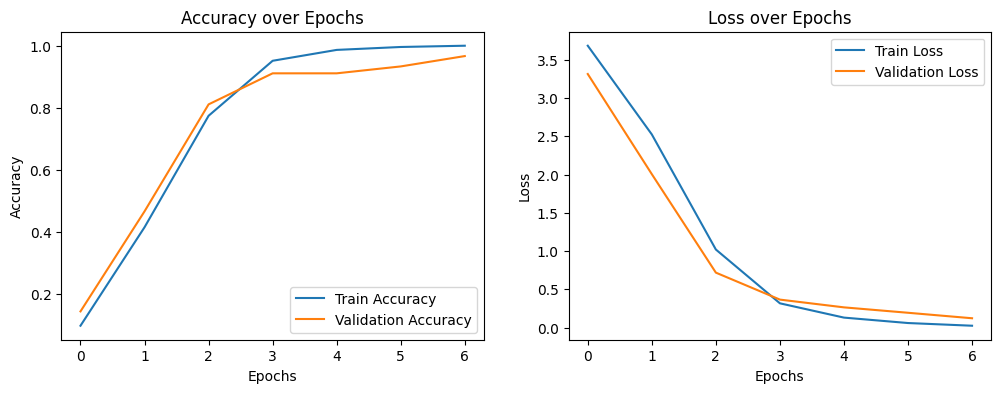

In [14]:
#Training the cnn with spliting 0.9 for training and 0.1 for testing
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import matplotlib.pyplot as plt


# Load and prepare features and split them for training and testing
def load_and_split_data(output_dir):
    """
    Load all the fused feature templates from the given directory and split the data into training and testing sets.
    - First two templates from each class are used for testing
    - Remaining templates are used for training
    """
    fused_features = []
    labels = []

    # Load data
    for file_name in sorted(os.listdir(output_dir)):
        if file_name.endswith(".npy"):
            feature = np.load(os.path.join(output_dir, file_name))
            label = int(file_name.split("_")[0])  # Extract class label from the file name
            fused_features.append(feature)
            labels.append(label)

    fused_features = np.array(fused_features)  # Shape: (num_samples, feature_length)
    labels = np.array(labels)  # Corresponding labels

    # Split into testing and training
    unique_labels = np.unique(labels)  # Get unique class labels
    train_features = []
    train_labels = []
    test_features = []
    test_labels = []

    # Split data per class
    for label in unique_labels:
        # Get all samples for the current class
        class_features = fused_features[labels == label]
        class_labels = labels[labels == label]

        # First two templates used for testing
        test_features.extend(class_features[:2])
        test_labels.extend(class_labels[:2])

        # The rest are used for training
        train_features.extend(class_features[2:])
        train_labels.extend(class_labels[2:])

    # Convert lists to NumPy arrays
    train_features = np.array(train_features)
    train_labels = np.array(train_labels)
    test_features = np.array(test_features)
    test_labels = np.array(test_labels)

    # Reshape to fit CNN's expected input shape
    train_features = train_features[..., np.newaxis]  # Shape: (num_train_samples, feature_length, 1)
    test_features = test_features[..., np.newaxis]  # Shape: (num_test_samples, feature_length, 1)

    return train_features, train_labels, test_features, test_labels


# Define the 1D CNN model
def create_1d_cnn_model(input_shape):
    """
    Create and compile the 1D CNN model for classification.
    """
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(45, activation='softmax')  # Output layer with 45 classes
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


# Main execution
output_dir = "/content/drive/MyDrive/templates"  # Set this to your fused features directory
train_features, train_labels, test_features, test_labels = load_and_split_data(output_dir)

# Create the model
model = create_1d_cnn_model(input_shape=(train_features.shape[1], 1))

# Train the model
history = model.fit(
    train_features, train_labels,
    epochs=7,
    batch_size=32,
    validation_data=(test_features, test_labels),
    verbose=2
)

# Evaluate the performance
train_loss, train_accuracy = model.evaluate(train_features, train_labels, verbose=0)
test_loss, test_accuracy = model.evaluate(test_features, test_labels, verbose=0)

print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()


Epoch 1/7
40/40 - 2s - 53ms/step - accuracy: 0.0857 - loss: 3.7011 - val_accuracy: 0.1619 - val_loss: 3.4658
Epoch 2/7
40/40 - 1s - 25ms/step - accuracy: 0.3802 - loss: 2.7086 - val_accuracy: 0.4540 - val_loss: 2.1841
Epoch 3/7
40/40 - 1s - 17ms/step - accuracy: 0.7405 - loss: 1.1810 - val_accuracy: 0.7238 - val_loss: 1.1172
Epoch 4/7
40/40 - 1s - 14ms/step - accuracy: 0.9071 - loss: 0.4647 - val_accuracy: 0.8667 - val_loss: 0.5403
Epoch 5/7
40/40 - 1s - 16ms/step - accuracy: 0.9810 - loss: 0.1509 - val_accuracy: 0.8921 - val_loss: 0.4279
Epoch 6/7
40/40 - 1s - 15ms/step - accuracy: 0.9968 - loss: 0.0695 - val_accuracy: 0.9206 - val_loss: 0.2967
Epoch 7/7
40/40 - 1s - 17ms/step - accuracy: 0.9992 - loss: 0.0322 - val_accuracy: 0.9238 - val_loss: 0.2242
Train Accuracy: 1.00
Test Accuracy: 0.92


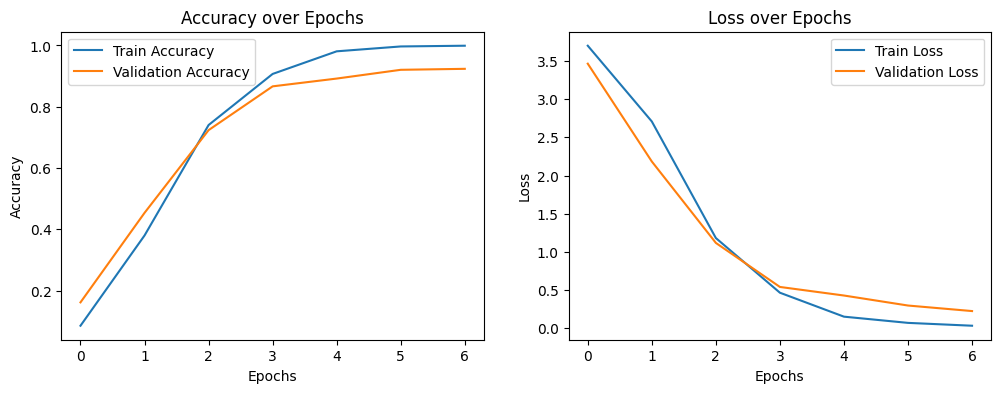

In [25]:
#Training the cnn with spliting 0.8 for training and 0.2 for testing

import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import matplotlib.pyplot as plt


# Shuffle templates per class to ensure feature variability
def shuffle_templates(output_dir):
    """
    Shuffle the templates (features) across each class to ensure variability in splits.
    """
    shuffled_features = []
    shuffled_labels = []

    # Loop through each class folder and shuffle the features
    for file_name in sorted(os.listdir(output_dir)):
        if file_name.endswith(".npy"):
            feature = np.load(os.path.join(output_dir, file_name))
            label = int(file_name.split("_")[0])  # Extract class label from the filename

            # Shuffle features randomly
            shuffled_features.append((label, feature))

    # Shuffle the entire list of features randomly
    np.random.shuffle(shuffled_features)

    # Separate shuffled features and their corresponding labels
    shuffled_features_array = np.array([item[1] for item in shuffled_features])
    shuffled_labels_array = np.array([item[0] for item in shuffled_features])

    return shuffled_features_array, shuffled_labels_array


# Load and split data with shuffling applied
def load_and_split_data(output_dir, test_fraction=0.2):
    """
    Randomly splits shuffled data into training and testing subsets.
    """
    # Shuffle templates
    shuffled_features, shuffled_labels = shuffle_templates(output_dir)

    # Split the data into train and test sets using test_fraction
    train_features, test_features, train_labels, test_labels = train_test_split(
        shuffled_features, shuffled_labels, test_size=test_fraction, random_state=42
    )

    # Reshape to fit CNN's expected input shape
    train_features = train_features[..., np.newaxis]  # Shape: (num_train_samples, feature_length, 1)
    test_features = test_features[..., np.newaxis]  # Shape: (num_test_samples, feature_length, 1)

    return train_features, train_labels, test_features, test_labels


# Create a 1D CNN model
def create_1d_cnn_model(input_shape):
    """
    Creates and compiles the CNN model architecture for classification.
    """
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(45, activation='softmax')  # 45 output classes
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


# Train and visualize
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy over time.
    """
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.show()


# Main execution
output_dir = "/content/drive/MyDrive/templates"  # Replace this with the actual directory path
train_features, train_labels, test_features, test_labels = load_and_split_data(output_dir, test_fraction=0.2)

# Create the CNN model
model = create_1d_cnn_model(input_shape=(train_features.shape[1], 1))

# Train the model
history = model.fit(
    train_features, train_labels,
    epochs=7,
    batch_size=32,
    validation_data=(test_features, test_labels),
    verbose=2
)

# Evaluate the performance
train_loss, train_accuracy = model.evaluate(train_features, train_labels, verbose=0)
test_loss, test_accuracy = model.evaluate(test_features, test_labels, verbose=0)

print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

# Visualize the training history
plot_training_history(history)


Epoch 1/6
40/40 - 2s - 62ms/step - accuracy: 0.0841 - loss: 3.6786 - val_accuracy: 0.1175 - val_loss: 3.3888 - learning_rate: 0.0010
Epoch 2/6
40/40 - 0s - 11ms/step - accuracy: 0.4238 - loss: 2.5647 - val_accuracy: 0.4698 - val_loss: 2.1096 - learning_rate: 0.0010
Epoch 3/6
40/40 - 1s - 15ms/step - accuracy: 0.7476 - loss: 1.1517 - val_accuracy: 0.6794 - val_loss: 1.1226 - learning_rate: 0.0010
Epoch 4/6
40/40 - 1s - 15ms/step - accuracy: 0.9167 - loss: 0.4242 - val_accuracy: 0.8159 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 5/6
40/40 - 0s - 10ms/step - accuracy: 0.9865 - loss: 0.1432 - val_accuracy: 0.8730 - val_loss: 0.5024 - learning_rate: 0.0010
Epoch 6/6
40/40 - 1s - 18ms/step - accuracy: 0.9960 - loss: 0.0711 - val_accuracy: 0.8762 - val_loss: 0.4034 - learning_rate: 0.0010
Train Accuracy: 1.00
Test Accuracy: 0.88


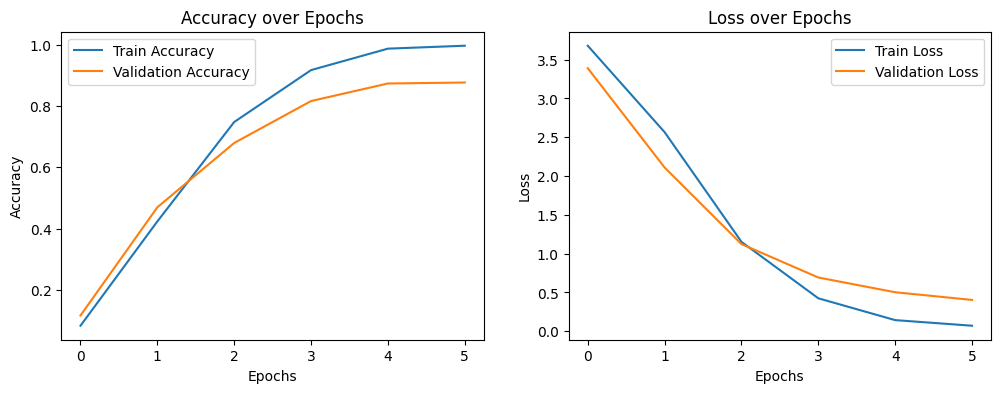

In [23]:
#Training the cnn with spliting 0.7 for training and 0.3 for testing

import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


# Shuffle templates per class to ensure variability in splits
def shuffle_templates(output_dir):
    """
    Shuffle the templates (features) across each class to ensure variability in splits.
    """
    shuffled_features = []
    shuffled_labels = []

    # Loop through each class folder and shuffle the features
    for file_name in sorted(os.listdir(output_dir)):
        if file_name.endswith(".npy"):
            feature = np.load(os.path.join(output_dir, file_name))
            label = int(file_name.split("_")[0])  # Extract class label from the filename

            # Shuffle features randomly
            shuffled_features.append((label, feature))

    # Shuffle the entire list of features randomly
    np.random.shuffle(shuffled_features)

    # Separate shuffled features and their corresponding labels
    shuffled_features_array = np.array([item[1] for item in shuffled_features])
    shuffled_labels_array = np.array([item[0] for item in shuffled_features])

    return shuffled_features_array, shuffled_labels_array


# Load and split data with shuffling applied
def load_and_split_data(output_dir, test_fraction=0.3):
    """
    Randomly splits shuffled data into training and testing subsets.
    """
    # Shuffle templates
    shuffled_features, shuffled_labels = shuffle_templates(output_dir)

    # Split the data into train and test sets using test_fraction
    train_features, test_features, train_labels, test_labels = train_test_split(
        shuffled_features, shuffled_labels, test_size=test_fraction, random_state=42
    )

    # Reshape to fit CNN's expected input shape
    train_features = train_features[..., np.newaxis]  # Shape: (num_train_samples, feature_length, 1)
    test_features = test_features[..., np.newaxis]  # Shape: (num_test_samples, feature_length, 1)

    return train_features, train_labels, test_features, test_labels


# Create a 1D CNN model
def create_1d_cnn_model(input_shape):
    """
    Creates and compiles the CNN model architecture for classification.
    """
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(45, activation='softmax')  # 45 output classes
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


# Train and visualize
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy over time.
    """
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.show()


# Main execution
output_dir = "/content/drive/MyDrive/templates"  # Replace this with the actual directory path
train_features, train_labels, test_features, test_labels = load_and_split_data(output_dir, test_fraction=0.2)

# Create the CNN model
model = create_1d_cnn_model(input_shape=(train_features.shape[1], 1))

# Set up EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Train the model with callbacks
history = model.fit(
    train_features, train_labels,
    epochs=6,  # Number of epochs
    batch_size=32,
    validation_data=(test_features, test_labels),
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Evaluate the performance
train_loss, train_accuracy = model.evaluate(train_features, train_labels, verbose=0)
test_loss, test_accuracy = model.evaluate(test_features, test_labels, verbose=0)

print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

# Visualize the training history
plot_training_history(history)


Epoch 1/7
17/17 - 2s - 131ms/step - accuracy: 0.0573 - loss: 3.7785 - val_accuracy: 0.1094 - val_loss: 3.6831 - learning_rate: 0.0010
Epoch 2/7
17/17 - 0s - 23ms/step - accuracy: 0.2672 - loss: 3.3590 - val_accuracy: 0.1608 - val_loss: 3.4609 - learning_rate: 0.0010
Epoch 3/7
17/17 - 0s - 19ms/step - accuracy: 0.4084 - loss: 2.7568 - val_accuracy: 0.2636 - val_loss: 3.0480 - learning_rate: 0.0010
Epoch 4/7
17/17 - 1s - 33ms/step - accuracy: 0.6298 - loss: 1.8663 - val_accuracy: 0.4272 - val_loss: 2.4124 - learning_rate: 0.0010
Epoch 5/7
17/17 - 0s - 21ms/step - accuracy: 0.7691 - loss: 1.1146 - val_accuracy: 0.4948 - val_loss: 2.0706 - learning_rate: 0.0010
Epoch 6/7
17/17 - 0s - 16ms/step - accuracy: 0.8340 - loss: 0.7155 - val_accuracy: 0.5652 - val_loss: 1.7062 - learning_rate: 0.0010
Epoch 7/7
17/17 - 0s - 18ms/step - accuracy: 0.9447 - loss: 0.3921 - val_accuracy: 0.6641 - val_loss: 1.4185 - learning_rate: 0.0010
Train Accuracy: 0.99
Test Accuracy: 0.66


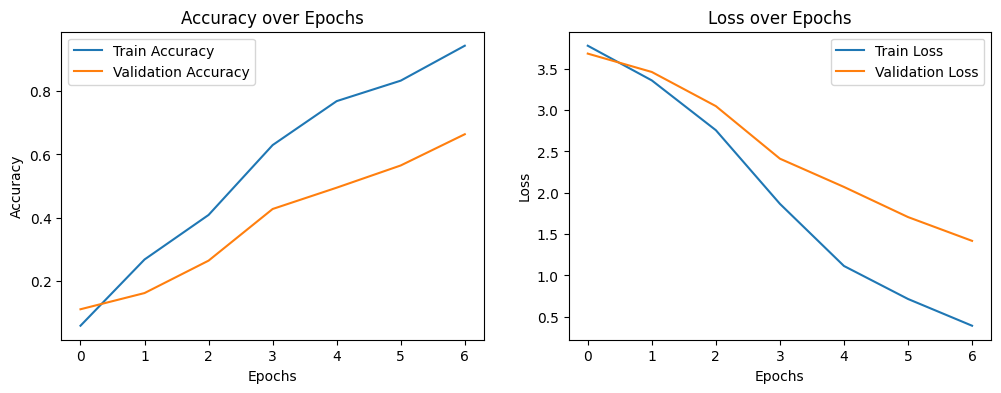

In [24]:
#Training the cnn with spliting 2/3 for training and 1/3 for testing

import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


# Shuffle templates per class to ensure variability in splits
def shuffle_templates(output_dir):
    """
    Shuffle the templates (features) across each class to ensure variability in splits.
    """
    shuffled_features = []
    shuffled_labels = []

    # Loop through each class folder and shuffle the features
    for file_name in sorted(os.listdir(output_dir)):
        if file_name.endswith(".npy"):
            feature = np.load(os.path.join(output_dir, file_name))
            label = int(file_name.split("_")[0])  # Extract class label from the filename

            # Shuffle features randomly
            shuffled_features.append((label, feature))

    # Shuffle the entire list of features randomly
    np.random.shuffle(shuffled_features)

    # Separate shuffled features and their corresponding labels
    shuffled_features_array = np.array([item[1] for item in shuffled_features])
    shuffled_labels_array = np.array([item[0] for item in shuffled_features])

    return shuffled_features_array, shuffled_labels_array


# Load and split data with shuffling applied
def load_and_split_data(output_dir, train_fraction=1 / 3):
    """
    Randomly splits shuffled data into training and testing subsets with 1/3 split.
    """
    # Shuffle templates
    shuffled_features, shuffled_labels = shuffle_templates(output_dir)

    # Split the data into train and test sets using train_fraction
    train_features, test_features, train_labels, test_labels = train_test_split(
        shuffled_features, shuffled_labels, test_size=(1 - train_fraction), random_state=42
    )

    # Reshape to fit CNN's expected input shape
    train_features = train_features[..., np.newaxis]  # Shape: (num_train_samples, feature_length, 1)
    test_features = test_features[..., np.newaxis]  # Shape: (num_test_samples, feature_length, 1)

    return train_features, train_labels, test_features, test_labels


# Create a 1D CNN model
def create_1d_cnn_model(input_shape):
    """
    Creates and compiles the CNN model architecture for classification.
    """
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(45, activation='softmax')  # 45 output classes
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


# Train and visualize
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy over time.
    """
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.show()


# Main execution
output_dir = "/content/drive/MyDrive/templates"  # Replace this with the actual directory path
train_features, train_labels, test_features, test_labels = load_and_split_data(output_dir, train_fraction=1/3)

# Create the CNN model
model = create_1d_cnn_model(input_shape=(train_features.shape[1], 1))

# Set up EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Train the model with callbacks
history = model.fit(
    train_features, train_labels,
    epochs=7,  # Number of epochs
    batch_size=32,
    validation_data=(test_features, test_labels),
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Evaluate the performance
train_loss, train_accuracy = model.evaluate(train_features, train_labels, verbose=0)
test_loss, test_accuracy = model.evaluate(test_features, test_labels, verbose=0)

print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

# Visualize the training history
plot_training_history(history)


Epoch 1/7
17/17 - 3s - 169ms/step - accuracy: 0.0439 - loss: 3.8352 - val_accuracy: 0.0695 - val_loss: 3.7255 - learning_rate: 0.0010
Epoch 2/7
17/17 - 1s - 39ms/step - accuracy: 0.2023 - loss: 3.5243 - val_accuracy: 0.1541 - val_loss: 3.5387 - learning_rate: 0.0010
Epoch 3/7
17/17 - 1s - 38ms/step - accuracy: 0.3302 - loss: 3.0517 - val_accuracy: 0.2027 - val_loss: 3.2025 - learning_rate: 0.0010
Epoch 4/7
17/17 - 1s - 36ms/step - accuracy: 0.5191 - loss: 2.2895 - val_accuracy: 0.3121 - val_loss: 2.7904 - learning_rate: 0.0010
Epoch 5/7
17/17 - 0s - 19ms/step - accuracy: 0.6889 - loss: 1.5571 - val_accuracy: 0.4491 - val_loss: 2.2599 - learning_rate: 0.0010
Epoch 6/7
17/17 - 1s - 37ms/step - accuracy: 0.8130 - loss: 0.9519 - val_accuracy: 0.5014 - val_loss: 1.9753 - learning_rate: 0.0010
Epoch 7/7
17/17 - 0s - 16ms/step - accuracy: 0.8989 - loss: 0.5704 - val_accuracy: 0.6099 - val_loss: 1.6300 - learning_rate: 0.0010

Final Performance Metrics:
Train Loss: 0.3384
Train Accuracy: 0.96


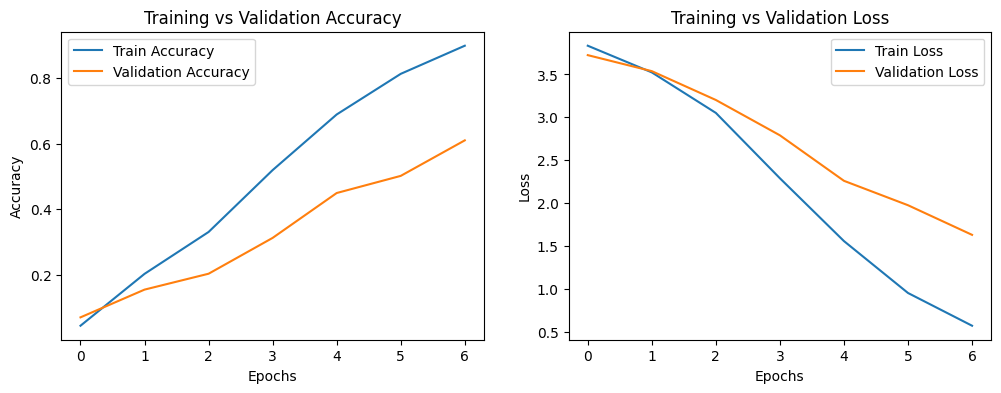

In [27]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


# Shuffle templates per class to ensure variability in splits
def shuffle_templates(output_dir):
    """
    Shuffle the templates (features) across each class to ensure variability in splits.
    """
    shuffled_features = []
    shuffled_labels = []

    # Loop through each class folder and shuffle the features
    for file_name in sorted(os.listdir(output_dir)):
        if file_name.endswith(".npy"):
            feature = np.load(os.path.join(output_dir, file_name))
            label = int(file_name.split("_")[0])  # Extract class label from the filename

            # Shuffle features randomly
            shuffled_features.append((label, feature))

    # Shuffle the entire list of features randomly
    np.random.shuffle(shuffled_features)

    # Separate shuffled features and their corresponding labels
    shuffled_features_array = np.array([item[1] for item in shuffled_features])
    shuffled_labels_array = np.array([item[0] for item in shuffled_features])

    return shuffled_features_array, shuffled_labels_array


# Load and split data with shuffling applied
def load_and_split_data(output_dir, train_fraction=1 / 3):
    """
    Randomly splits shuffled data into training and testing subsets with a 1/3 split.
    """
    # Shuffle templates
    shuffled_features, shuffled_labels = shuffle_templates(output_dir)

    # Split the data into train and test sets using the given train_fraction
    train_features, test_features, train_labels, test_labels = train_test_split(
        shuffled_features, shuffled_labels, test_size=(1 - train_fraction), random_state=42
    )

    # Reshape to fit CNN's expected input shape
    train_features = train_features[..., np.newaxis]  # Shape: (num_train_samples, feature_length, 1)
    test_features = test_features[..., np.newaxis]  # Shape: (num_test_samples, feature_length, 1)

    return train_features, train_labels, test_features, test_labels


# Create CNN Model
def create_1d_cnn_model(input_shape):
    """
    Creates and compiles the CNN model architecture for classification.
    """
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(45, activation='softmax')  # Output classes = 45
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


# Plot Training History
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy over time.
    """
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    plt.show()


# Generate the entire report
def generate_report(output_dir):
    """
    Trains the model and generates performance insights (visualizations and metrics).
    """
    # Load and split data
    train_features, train_labels, test_features, test_labels = load_and_split_data(
        output_dir, train_fraction=1 / 3
    )

    # Create the CNN model
    model = create_1d_cnn_model(input_shape=(train_features.shape[1], 1))

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

    # Train the model
    history = model.fit(
        train_features, train_labels,
        epochs=7,
        batch_size=32,
        validation_data=(test_features, test_labels),
        callbacks=[early_stopping, reduce_lr],
        verbose=2
    )

    # Evaluate the performance
    train_loss, train_accuracy = model.evaluate(train_features, train_labels, verbose=0)
    test_loss, test_accuracy = model.evaluate(test_features, test_labels, verbose=0)

    print("\nFinal Performance Metrics:")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.2f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}")

    # Generate training history plots
    plot_training_history(history)


# Call to generate the report
output_dir = "/content/drive/MyDrive/templates"  # Replace this with your path
generate_report(output_dir)


Epoch 1/8
17/17 - 2s - 136ms/step - accuracy: 0.0439 - loss: 3.7921 - val_accuracy: 0.0485 - val_loss: 3.7271 - learning_rate: 0.0010
Epoch 2/8
17/17 - 1s - 57ms/step - accuracy: 0.2176 - loss: 3.4357 - val_accuracy: 0.1589 - val_loss: 3.4985 - learning_rate: 0.0010
Epoch 3/8
17/17 - 0s - 28ms/step - accuracy: 0.4160 - loss: 2.8820 - val_accuracy: 0.3416 - val_loss: 3.0242 - learning_rate: 0.0010
Epoch 4/8
17/17 - 1s - 38ms/step - accuracy: 0.6393 - loss: 2.0044 - val_accuracy: 0.4434 - val_loss: 2.4201 - learning_rate: 0.0010
Epoch 5/8
17/17 - 1s - 33ms/step - accuracy: 0.7939 - loss: 1.2095 - val_accuracy: 0.5309 - val_loss: 1.9469 - learning_rate: 0.0010
Epoch 6/8
17/17 - 1s - 36ms/step - accuracy: 0.8702 - loss: 0.6801 - val_accuracy: 0.6461 - val_loss: 1.4690 - learning_rate: 0.0010
Epoch 7/8
17/17 - 0s - 26ms/step - accuracy: 0.9485 - loss: 0.3568 - val_accuracy: 0.6822 - val_loss: 1.2396 - learning_rate: 0.0010
Epoch 8/8
17/17 - 0s - 27ms/step - accuracy: 0.9828 - loss: 0.1910 -

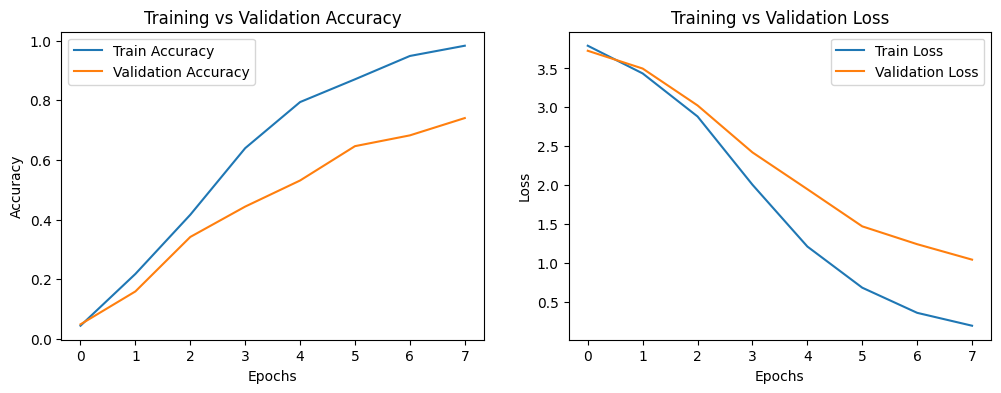

In [29]:
#Spliting training as 0.75 testing 0.25
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


# Shuffle templates per class to ensure variability in splits
def shuffle_templates(output_dir):
    """
    Shuffle the templates (features) across each class to ensure variability in splits.
    """
    shuffled_features = []
    shuffled_labels = []

    # Loop through each class folder and shuffle the features
    for file_name in sorted(os.listdir(output_dir)):
        if file_name.endswith(".npy"):
            feature = np.load(os.path.join(output_dir, file_name))
            label = int(file_name.split("_")[0])  # Extract class label from the filename

            # Shuffle features randomly
            shuffled_features.append((label, feature))

    # Shuffle the entire list of features randomly
    np.random.shuffle(shuffled_features)

    # Separate shuffled features and their corresponding labels
    shuffled_features_array = np.array([item[1] for item in shuffled_features])
    shuffled_labels_array = np.array([item[0] for item in shuffled_features])

    return shuffled_features_array, shuffled_labels_array


# Load and split data with shuffling applied
def load_and_split_data(output_dir, train_fraction= 0.25):
    """
    Randomly splits shuffled data into training and testing subsets with a 1/3 split.
    """
    # Shuffle templates
    shuffled_features, shuffled_labels = shuffle_templates(output_dir)

    # Split the data into train and test sets using the given train_fraction
    train_features, test_features, train_labels, test_labels = train_test_split(
        shuffled_features, shuffled_labels, test_size=(1 - train_fraction), random_state=42
    )

    # Reshape to fit CNN's expected input shape
    train_features = train_features[..., np.newaxis]  # Shape: (num_train_samples, feature_length, 1)
    test_features = test_features[..., np.newaxis]  # Shape: (num_test_samples, feature_length, 1)

    return train_features, train_labels, test_features, test_labels


# Create CNN Model
def create_1d_cnn_model(input_shape):
    """
    Creates and compiles the CNN model architecture for classification.
    """
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(45, activation='softmax')  # Output classes = 45
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


# Plot Training History
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy over time.
    """
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    plt.show()


# Generate the entire report
def generate_report(output_dir):
    """
    Trains the model and generates performance insights (visualizations and metrics).
    """
    # Load and split data
    train_features, train_labels, test_features, test_labels = load_and_split_data(
        output_dir, train_fraction=1 / 3
    )

    # Create the CNN model
    model = create_1d_cnn_model(input_shape=(train_features.shape[1], 1))

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

    # Train the model
    history = model.fit(
        train_features, train_labels,
        epochs=8,
        batch_size=32,
        validation_data=(test_features, test_labels),
        callbacks=[early_stopping, reduce_lr],
        verbose=2
    )

    # Evaluate the performance
    train_loss, train_accuracy = model.evaluate(train_features, train_labels, verbose=0)
    test_loss, test_accuracy = model.evaluate(test_features, test_labels, verbose=0)

    print("\nFinal Performance Metrics:")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.2f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}")

    # Generate training history plots
    plot_training_history(history)


# Call to generate the report
output_dir = "/content/drive/MyDrive/templates"  # Replace this with your path
generate_report(output_dir)
